# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.283091,True,5.199643
1,-0.353235,False,-1.515609
2,-0.015820,False,-0.519809
3,1.821454,True,4.295236
4,1.612702,True,5.995519
...,...,...,...
995,-0.142148,False,-1.595339
996,0.942191,True,5.204843
997,2.382742,True,4.669635
998,0.899885,True,4.992588


<AxesSubplot:xlabel='v0'>

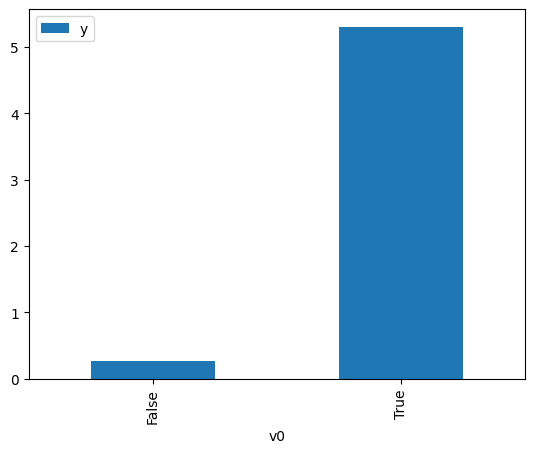

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

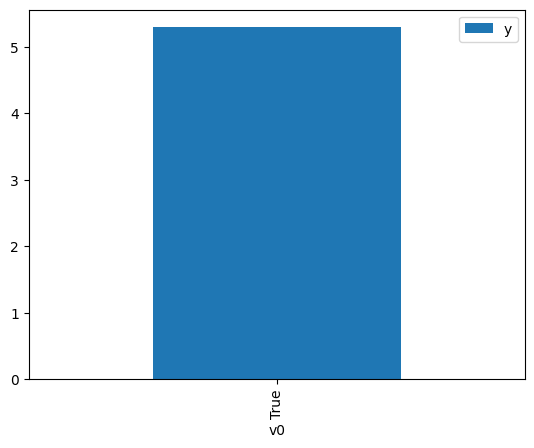

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.557518,False,0.913513,0.599249,1.668756
1,1.813659,False,1.834664,0.218017,4.586802
2,2.476593,False,1.610868,0.148446,6.736466
3,0.187859,False,-1.028751,0.468630,2.133879
4,-0.655886,False,-0.697190,0.615860,1.623745
...,...,...,...,...,...
995,-0.001037,False,1.128471,0.502040,1.991875
996,2.281858,False,0.660271,0.166741,5.997336
997,2.238283,False,0.334788,0.171073,5.845446
998,2.191749,False,1.555940,0.175798,5.688332


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.580402,True,6.212393,0.752509,1.328888
1,0.555505,True,5.437542,0.595334,1.679728
2,0.530545,True,4.743584,0.591068,1.691853
3,2.717871,True,5.844916,0.871887,1.146937
4,-0.606583,True,2.743568,0.392434,2.548196
...,...,...,...,...,...
995,0.728804,True,6.456612,0.624529,1.601207
996,-2.000898,True,2.180986,0.193920,5.156767
997,2.311058,True,7.053158,0.836113,1.196010
998,2.318176,True,7.168554,0.836803,1.195025


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8191.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):                        0.00
Time:                        20:10:19   Log-Likelihood:                         -1460.9
No. Observations:                1000   AIC:                                      2926.
Df Residuals:                     998   BIC:                                      2936.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3377      0.033     10.099      0.000       0.272       0.403
x2             5.0636      0.053     94.895      0.000       4.959       5.168
==============================================================================
Omnibus:                        5.173   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                4.178
Skew:                          -0.056   Prob(JB):                        0.124
Kurtosis:                       2.703   Cond. No.                         2.39
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""